In [1]:
import numpy as np
from numpy.random import default_rng

import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

## 1. Generate data

(10000, 5)


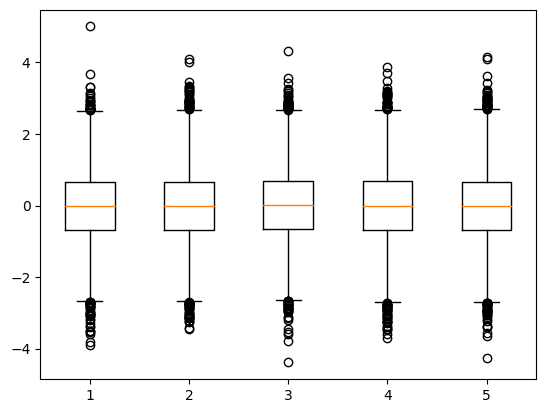

In [2]:
n_samples, n_features = 10_000, 5
data = default_rng(42).normal(size=(n_samples, n_features))
print(data.shape)
plt.boxplot(data)
plt.show()

The data is generated completely randomly, there should be no relationships whatsoever. This makes the "features" useless.  The model will either overfit on this specific data; or achieve an accuracy near the 1/N_classes.

We will have three classes, A, B, and C, with A class being heavily over-represented (80% of all samples):

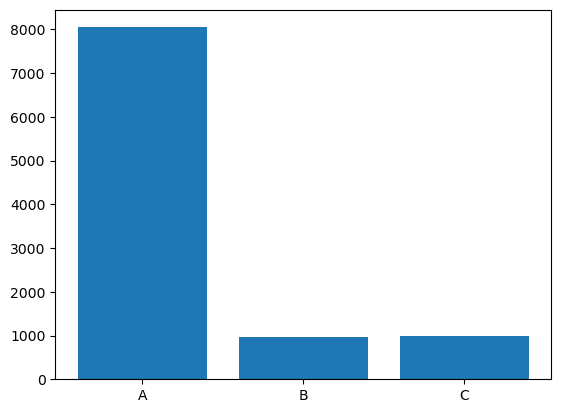

In [3]:
Y = default_rng(42).choice(['A', 'B', 'C'], p=[.8, .1, .1], size=n_samples)
plt.bar(*np.unique(Y, return_counts=True))
plt.show()

We don't need to normalize the data as it is already normal.

## 2. Train a model

There's no reason why Random Forest was chosen - any other model would produce similar results.

In [4]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42
)

In [5]:
x_train, x_test, y_train, y_test = train_test_split(data, Y, test_size=.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((8000, 5), (2000, 5), (8000,), (2000,))

We can check that all the classes are present in both train and test data, with very similar ratios:

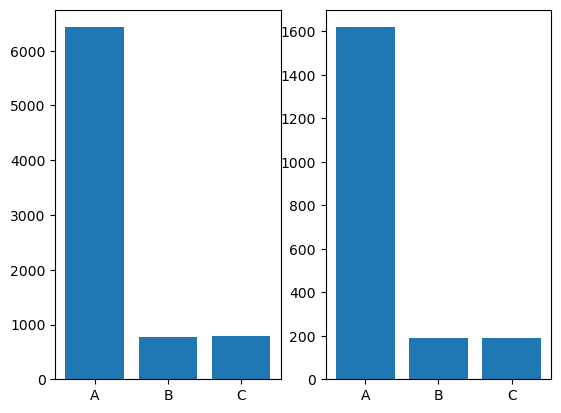

In [6]:
fig, ax = plt.subplots(1, 2)
ax[0].bar(*np.unique(y_train, return_counts=True))
ax[1].bar(*np.unique(y_test, return_counts=True))
plt.show()

Now, when we fit the model, we get quite good results it seems. We have ~80% accuracy for both train and test, so the model is good and not overfit, right? ...right?

In [7]:
model.fit(x_train, y_train)
train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)
print(f'Train score: {train_acc:.2f} | Test score: {test_acc:.2f}')

Train score: 0.80 | Test score: 0.81


### Unbalanced data: detect the problem

What we see here actually is the percent of the A class in the data! Check confusion matrix:

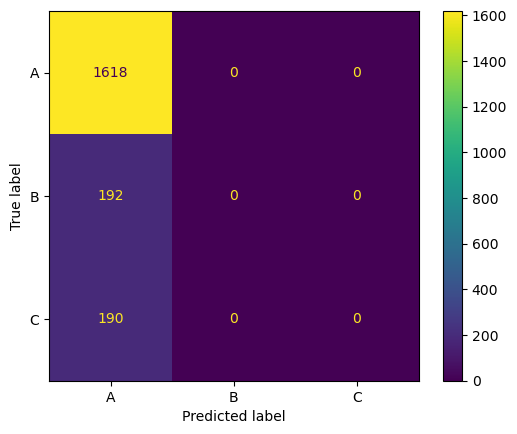

In [8]:
ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)
plt.show()

All test samples were predicted as A class, because this is a very easy way for a model to obtain high accuracy!

How to detect such a situation if we work with unbalanced data? The accuracy metric can be quite misleading in such cases, so it is beneficial to always check other metrics as well. There are other two classical metrics: precision and recall.

There are even more metrics; one of  popular ones is the F1 metric, but precision and recall are more fundamental.

So, the accuracy metric is the number of correctly predicted samples divided by the number of all samples:

- Accuracy: `(TP + TN) / n`

Here, `n` is the number of all samples. `TP` stands for True Positives, which are samples predicted correctly for that class (e.g. A class samples predicted as A). `TN` stands for True Negatives, which only is relevant for binary data (having two classes). In case of three and more classes, the accuracy formula can be generalized as:

- Multi-class accuracy: n_correct_predictions / n_all_predictions

This is just the sum of diagonal divided by number of samples. And in the case above, we have high accuracy because we have a huge number of "correctly" predicted A class - about 80%, which is its initial ratio in the data.

Precision shows a different thing:

- Precision: `TP / (TP + FP)`

Here, `FP` stands for False Positives. In case of our multi-class data, FPs are all samples which were predicted as A class but are actually other classes. Usually prediction is calculated for each class then averaged; this is called _macro_ precision. As we have no predictions for classes B and C (no Positives), we cannot even calculate their precision because we would need to divide by zero. That's why we get warnings in case of this notebook.

Recall shows how many of A class samples were predicted as A class samples:

- Recall: `TP / (TP + FN)`

Recall per class may be the best metric to detect this class over-representation problem: one class will have a perfect recall and all others will have zeros.

Note: ensure you use the correct formula! scikit-learn provides micro, macro, and weighted for precision and recall metrics, from which macro is the the helpful one (or use `average=None` to get metrics per class):

In [9]:
y_pred = model.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred), '\n')

for average in ['micro', 'macro', 'weighted']:
    print(f'{average} precision:', precision_score(y_test, y_pred, average=average))
    print(f'{average} recall:', recall_score(y_test, y_pred, average=average))
    print('')
    
print('Precision per class:', precision_score(y_test, y_pred, average=None))
print('Recall per class:', recall_score(y_test, y_pred, average=None))

Accuracy: 0.809 

micro precision: 0.809
micro recall: 0.809

macro precision: 0.26966666666666667
macro recall: 0.3333333333333333

weighted precision: 0.654481
weighted recall: 0.809

Precision per class: [0.809 0.    0.   ]
Recall per class: [1. 0. 0.]


C:\Users\Admin\miniconda3\envs\universal\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\miniconda3\envs\universal\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\miniconda3\envs\universal\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## How to solve this problem?

There are two main approaches:

1. Balance your data: remove random samples from the over-represented class (downsampling). It is also possible to upsample your data, but it won't be shown in this notebook and mostly makes sense for image data.
2. Use a different training approach, which usually means changing the loss function: e.g. use a bigger penalty for errors in under-represented classes.

### Balancing the data

(2954, 5) (2954,)


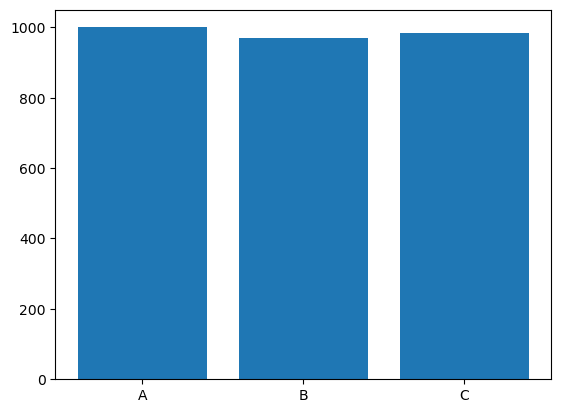

In [10]:
ix_to_keep = np.hstack([
    np.where(Y != 'A')[0],
    default_rng(42).choice(np.where(Y == 'A')[0], size=int(n_samples * 0.1))
])
data_balanced = data[ix_to_keep]
Y_balanced = Y[ix_to_keep]

print(data_balanced.shape, Y_balanced.shape)

plt.bar(*np.unique(Y_balanced, return_counts=True))
plt.show()

In [11]:
x_train_b, x_test_b, y_train_b, y_test_b = train_test_split(data_balanced, Y_balanced,
                                                            test_size=.2, random_state=42)
x_train_b.shape, x_test_b.shape, y_train_b.shape, y_test_b.shape

((2363, 5), (591, 5), (2363,), (591,))

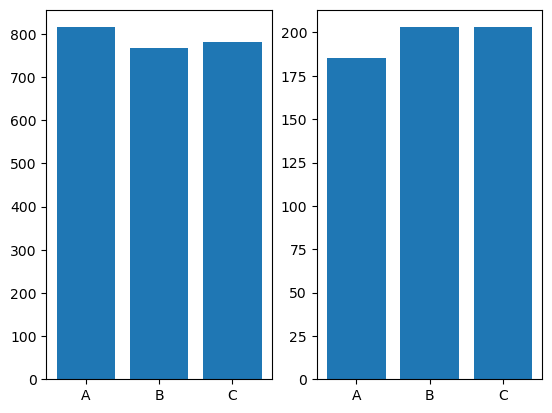

In [12]:
fig, ax = plt.subplots(1, 2)
ax[0].bar(*np.unique(y_train_b, return_counts=True))
ax[1].bar(*np.unique(y_test_b, return_counts=True))
plt.show()

In [13]:
model.fit(x_train_b, y_train_b)
train_acc = model.score(x_train_b, y_train_b)
test_acc = model.score(x_test_b, y_test_b)
print(f'Train score: {train_acc:.2f} | Test score: {test_acc:.2f}')

Train score: 0.43 | Test score: 0.36


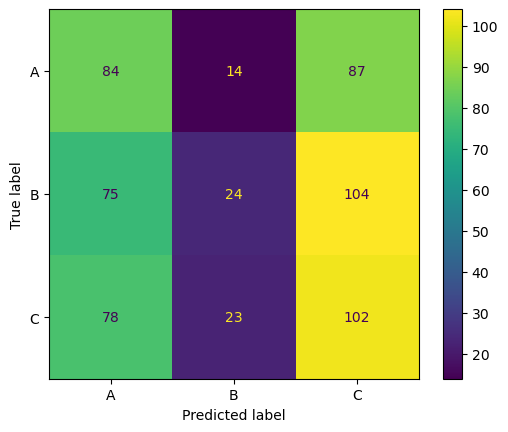

In [14]:
ConfusionMatrixDisplay.from_estimator(model, x_test_b, y_test_b)
plt.show()

Now these results look more realistic for our random data. There still may be some under-representation of a class, but the important thing is that we don't get that misleading high accuracy anymore.

### Weighting classes with scikit-learn

All scikit-learn classifiers should have this additional parameter `class_weight` which can receive the "importance" of each class:

Train score: 0.52 | Test score: 0.48


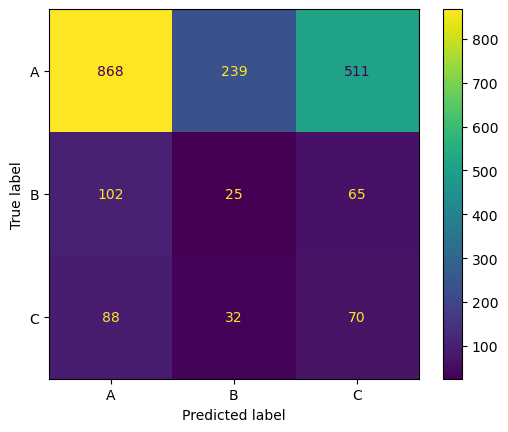

In [15]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42,
    class_weight={'A': 1, 'B': 8, 'C': 8}
)

model.fit(x_train, y_train)
train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)
print(f'Train score: {train_acc:.2f} | Test score: {test_acc:.2f}')

ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)
plt.show()

Alternatively, you can tell it to balance itself:

Train score: 0.34 | Test score: 0.30


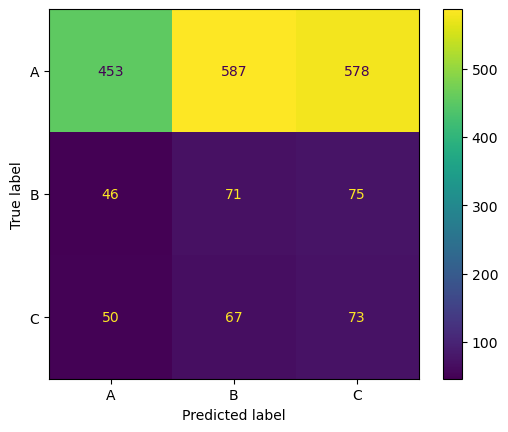

In [16]:
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=3,
    random_state=42,
    class_weight='balanced'
)

model.fit(x_train, y_train)
train_acc = model.score(x_train, y_train)
test_acc = model.score(x_test, y_test)
print(f'Train score: {train_acc:.2f} | Test score: {test_acc:.2f}')

ConfusionMatrixDisplay.from_estimator(model, x_test, y_test)
plt.show()

When we have balanced results, class recalls will be similar:

In [17]:
y_pred = model.predict(x_test)

print('Accuracy:', accuracy_score(y_test, y_pred), '\n')

for average in ['micro', 'macro', 'weighted']:
    print(f'{average} precision:', precision_score(y_test, y_pred, average=average))
    print(f'{average} recall:', recall_score(y_test, y_pred, average=average))
    print('')
    
print('Precision per class:', precision_score(y_test, y_pred, average=None))
print('Recall per class:', recall_score(y_test, y_pred, average=None))

Accuracy: 0.2985 

micro precision: 0.2985
micro recall: 0.2985

macro precision: 0.3412062035639815
macro recall: 0.34465915703453104

weighted precision: 0.686489240033824
weighted recall: 0.2985

Precision per class: [0.82513661 0.09793103 0.10055096]
Recall per class: [0.27997528 0.36979167 0.38421053]
